In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset

from bfn.bfn_discrete import VanillaBFNDiscrete
from models.vanilla_net import VanillaNetDiscrete

/home/krisztina/Documents/MLMI/Advanced_ML/BayesianFlowNetworks/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


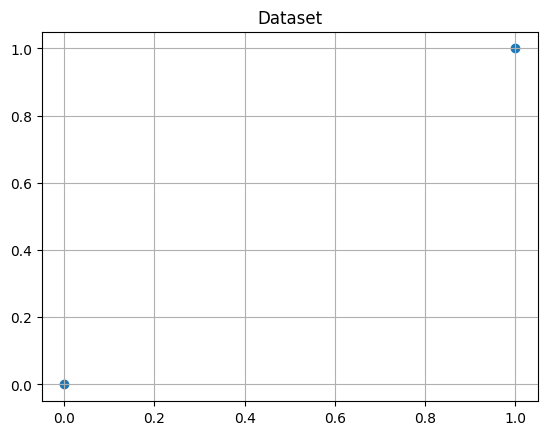

In [2]:
# network should learn
# when x0=0, x1=1
# when x0=1, x1=0

def get_datapoint(batch=128, device="cpu"):
  x0 = torch.randint(low=0, high=2, size=(batch,), dtype=torch.bool, device=device) # (batch,)
  x1 = ~x0

  X = torch.stack([x0, x1], dim=0) # (2, batch)
  return X.long().transpose(0,1) # (batch, 2)

X = get_datapoint() # (B, D=2) K = 2 classes

plt.title("Dataset")
plt.scatter(X[0,:], X[1,:])
plt.grid()

  0%|          | 0/1000 [00:00<?, ?it/s]/home/krisztina/Documents/MLMI/Advanced_ML/BayesianFlowNetworks/.conda/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 1000/1000 [00:01<00:00, 751.17it/s]


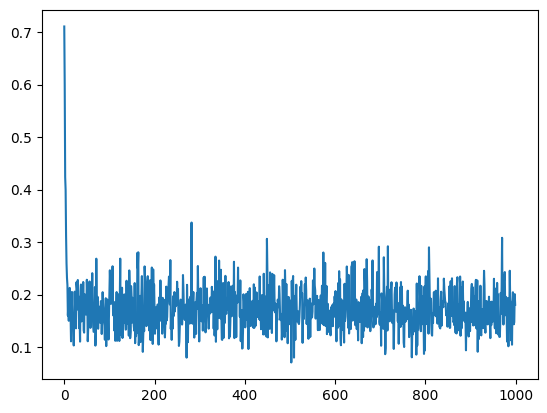

In [3]:
from torch.optim import AdamW
from tqdm.auto import tqdm

network = VanillaNetDiscrete(D=2, K=2, hidden_dim=128)
bfn = VanillaBFNDiscrete(K=2, D=2, model=network)
#bfn.cuda()

optim = AdamW(bfn.parameters(), lr=1e-2)

n=1000
losses=[]
for i in tqdm(range(n)):
  optim.zero_grad()

  X = get_datapoint(device="cpu")
  loss = bfn.training_continuous_loss(X)
  loss.backward()

  optim.step()

  losses.append(loss.item())
plt.plot(losses)

In [4]:
x_hat = bfn.sample(batch_size=128, device="cpu", n_steps=1000).cpu().numpy()
x_hat = x_hat + (np.random.randn(*x_hat.shape) * 0.1)

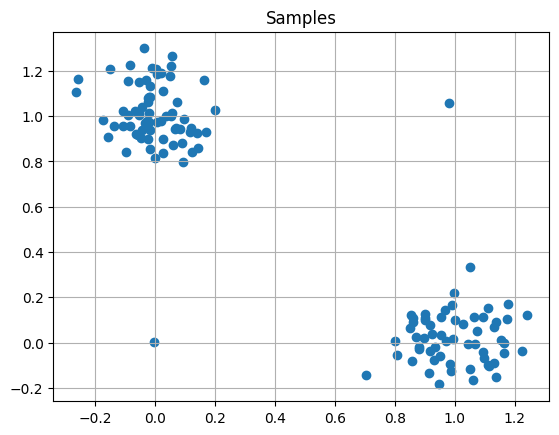

In [5]:
plt.title("Samples")
plt.scatter(x_hat[:, 0], x_hat[:, 1])
plt.grid()